In [1]:
import psycopg2 as pg
import pandas.io.sql as psql
import gmplot 
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
import gc
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')
import time
import copy


In [3]:
start_time = time.time()
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [4]:
#Check if the hostname and port are correct
hostname = 'localhost'
port = 5432


# Try using a connection URI
connection = pg.connect(f"host={hostname} port={port} dbname=jyoti_dp user=postgres password=Astrio@24")

# Read data from the database
#updated_pud = psql.read_sql('SELECT * FROM updated_pud', connection)
#cargo_vessels = psql.read_sql('SELECT * FROM cargo_vessels_ais', connection)

In [17]:
def calculate_bounding_box(latitude, longitude, height, width):
    # Calculate half height and width
    half_height = height / 2
    half_width = width / 2
    
    # Calculate bounding box coordinates
    min_lat = latitude - half_height
    max_lat = latitude + half_height
    min_lng = longitude - half_width
    max_lng = longitude + half_width
    
    return min_lat, max_lat, min_lng, max_lng

In [18]:
def bounding_box_plot(port_code,height,width):
    #Reading Port coordinates file and fetching longitude and latitude
    updated_pud = psql.read_sql('SELECT * FROM updated_pud', connection)
    
    lgb_lon=updated_pud.loc[updated_pud['un_locode']==port_code,'longitude'].values[0]
    lgb_lat=updated_pud.loc[updated_pud['un_locode']==port_code,'latitude'].values[0]
    # Calculate bounding box
    min_lat, max_lat, min_lng, max_lng = calculate_bounding_box(lgb_lat, lgb_lon, height, width)
    # Initialize the map with the first coordinate
    gmap = gmplot.GoogleMapPlotter(lgb_lat, lgb_lon, 19)
    gmap.marker(lgb_lat, lgb_lon, color='darkgreen',label='US LGB') 

    # Plot the bounding box
    bounding_box_lats = [min_lat, min_lat, max_lat, max_lat, min_lat]
    bounding_box_lngs = [min_lng, max_lng, max_lng, min_lng, min_lng]
    gmap.plot(bounding_box_lats, bounding_box_lngs, 'cornflowerblue',edge_width=3, edge_alpha=0.6, edge_style='dotted')
    
    # Read longitude and latitude points from AIS file of only cargo vessels
    cargo_vessels = psql.read_sql('SELECT * FROM cargo_vessels_ais', connection)

    #AIS data with 
    #Plotting only a sample of AIS file for visualizing the bounding box
    sample_cargo_data=cargo_vessels.iloc[:10000]
    
    # Add markers to the map for each point
    for index, row in sample_cargo_data.iterrows():
      gmap.marker(row['lat'], row['lon'], color='red')  
    # Save the map
    gmap.draw("bounding_box_withMarkers.html")

    # Filter the dataframe to select points falling within the bounding box
    subset_cargo_vessels = cargo_vessels[(cargo_vessels['lat'] >= min_lat) & (cargo_vessels['lat'] <= max_lat) &
               (cargo_vessels['lon'] >= min_lng) & (cargo_vessels['lon'] <= max_lng)]
    return(subset_cargo_vessels)

In [21]:
#subset_cargo_vessels.to_csv('D:\Jyoti_DP_Assignment\Data\subset_cargo_vessels.csv')

In [5]:
#subset_cargo_vessels=pd.read_csv('D:\Jyoti_DP_Assignment\Data\subset_cargo_vessels.csv')

In [39]:
def vessels_at_port(port_code):
    #Defining the bounding box to sample down the data.
    height=0.2
    width=0.2
    subset_cargo_vessels=bounding_box_plot(port_code,height,width)
    #the Number of unique cargo vessels within the port of Long Beach, throughout the day
    #Convert basedatetime to date time format
    subset_cargo_vessels['basedatetime'] = pd.to_datetime(subset_cargo_vessels['basedatetime'])
    # Combine date and hour into a single datetime column
    subset_cargo_vessels['date_hour_combined'] = subset_cargo_vessels.apply(lambda row: pd.Timestamp(row['basedatetime'].date()) + pd.Timedelta(hours=row['basedatetime'].hour), axis=1)

    vessel_df=subset_cargo_vessels.groupby('date_hour_combined').agg(distinct_vessels=('vesselname', 'nunique'))
    vessel_df.reset_index(inplace=True)
    return(vessel_df)


In [40]:
vessel_df=vessels_at_port('US LGB')

In [41]:
vessel_df.head()

,date_hour_combined,distinct_vessels
0,2020-01-01 00:00:00,17
1,2020-01-01 01:00:00,16
2,2020-01-01 02:00:00,15
3,2020-01-01 03:00:00,14
4,2020-01-01 04:00:00,15


In [44]:
import plotly.express as px

In [57]:
# Calculate differences between consecutive values
vessel_df['difference'] = vessel_df['distinct_vessels'].diff()

# Define threshold for significant jump
threshold = 3  # Adjust as needed

# Identify points where the difference exceeds the threshold
significant_jumps = vessel_df[vessel_df['difference'].abs() > threshold]

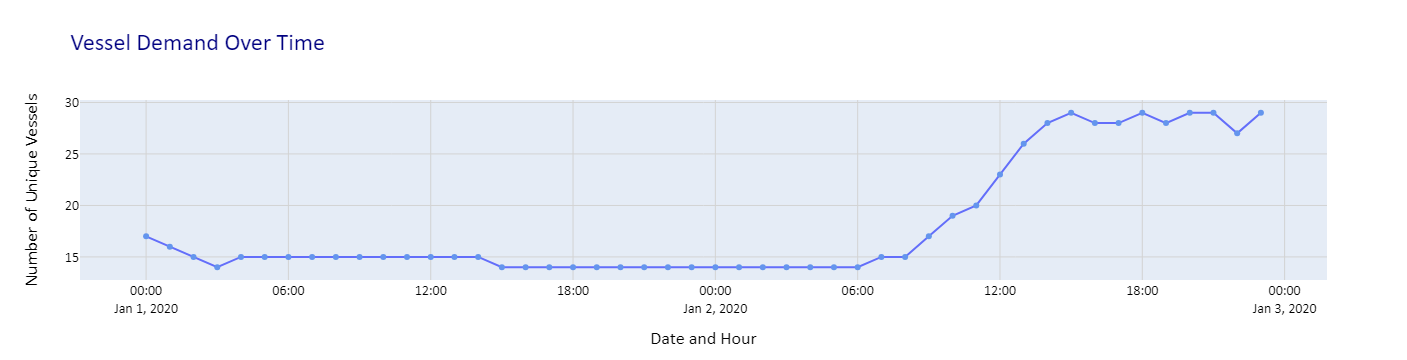

In [94]:
# Plot
fig = px.line(vessel_df, x='date_hour_combined', y='distinct_vessels', title='Vessel Demand Over Time',
              hover_data={'date_hour_combined': '|%Y-%m-%d %H:%M:%S', 'distinct_vessels': True},
              markers=True)

# Customizing layout
fig.update_layout(
    title_font_color="navy",
    title_font_family="Calibri",
    title_font_size=24,
    xaxis_title="Date and Hour",
    yaxis_title="Number of Unique Vessels",
    xaxis=dict(
        title_font_family="Calibri",
        title_font_color="black",
        title_font_size=18,
        tickfont=dict(family="Calibri", size=14, color="black"),
        showgrid=True,
        gridcolor="lightgray"
    ),
    yaxis=dict(
        title_font_family="Calibri",
        title_font_color="black",
        title_font_size=18,
        tickfont=dict(family="Calibri", size=14, color="black"),
        showgrid=True,
        gridcolor="lightgray"
    ),
    legend=dict(
        title="Legend",
        title_font_family="Calibri",
        title_font_size=16,
        font=dict(family="Calibri", size=14, color="black"),
        bgcolor="rgba(255, 255, 255, 0.5)",
        bordercolor="black",
        borderwidth=1
    ),
   # plot_bgcolor='rgba(0,0,0,0)' , # Make plot background fully transparent
    hoverlabel=dict(
        bgcolor="white",  # Set background color of hover label
        font=dict(family="Calibri", size=15, color="black"))  # Set font properties of hover label
)

# Customizing marker properties
fig.update_traces(marker=dict(size=6, color='cornflowerblue', symbol='circle'))

fig.show()


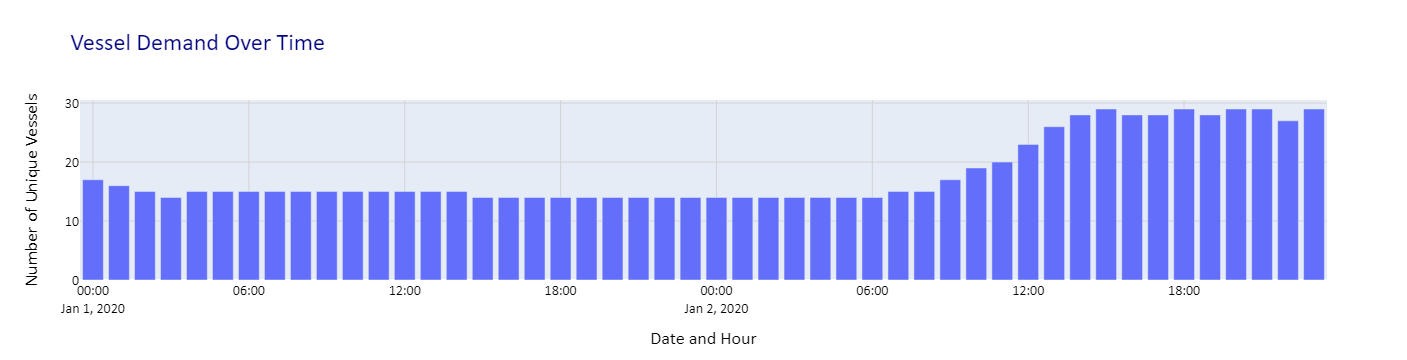

In [91]:
# Plot
fig = px.bar(vessel_df, x='date_hour_combined', y='distinct_vessels', title='Vessel Demand Over Time',
              hover_data={'date_hour_combined': '|%Y-%m-%d %H:%M:%S', 'distinct_vessels': True})

# Customizing layout
fig.update_layout(
    title_font_color="navy",
    title_font_family="Calibri",
    title_font_size=24,
    xaxis_title="Date and Hour",
    yaxis_title="Number of Unique Vessels",
    xaxis=dict(
        title_font_family="Calibri",
        title_font_color="black",
        title_font_size=18,
        tickfont=dict(family="Calibri", size=14, color="black"),
        showgrid=True,
        gridcolor="lightgray"
    ),
    yaxis=dict(
        title_font_family="Calibri",
        title_font_color="black",
        title_font_size=18,
        tickfont=dict(family="Calibri", size=14, color="black"),
        showgrid=True,
        gridcolor="lightgray"
    ),
    legend=dict(
        title="Legend",
        title_font_family="Calibri",
        title_font_size=16,
        font=dict(family="Calibri", size=14, color="black"),
        bgcolor="rgba(255, 255, 255, 0.5)",
        bordercolor="black",
        borderwidth=1
    ),
   # plot_bgcolor='rgba(0,0,0,0)' , # Make plot background fully transparent
    hoverlabel=dict(
        bgcolor="white",  # Set background color of hover label
        font=dict(family="Calibri", size=15, color="black"))  # Set font properties of hover label
)

fig.show()